In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
#44009 and 44065 were the two buoys lying right on the trajectory of the hurricane 
#so we decided to use them to analyse the data further
df_b7_init = pd.read_csv('/Users/shreyabanerjee/DA_proj/clean_csvs/44009_clean.csv')
df_b8_init = pd.read_csv('/Users/shreyabanerjee/DA_proj/clean_csvs/44065_clean.csv')

In [3]:
#A function to visualise the variation of pressure and windspeed together 
def plot_df(df, x,y1, y2, title, xlabel,data ,dpi=100):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(111)
    ax1.plot(x, y1)
    ax1.set_ylabel('Windspeed')
    ax1.set_xlabel(xlabel)
    ax1.set_title(title)
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'r-')
    ax2.set_ylabel('Pressure', color='r')
    if(data=='year'):
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
        ax1.xaxis.set_major_formatter(plt.NullFormatter())
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
        
    plt.tight_layout()

In [4]:
#Since buoy ID does not contribute to any prediction and is same throughout the csv, we won't keep it for analysis
keep_col = ['day','month','datetime','waveperiod','waveheight','WindDir','windspeed','pressure','possibility','hurrthreat']
df_b7 = df_b7_init[keep_col]
df_b8=df_b8_init[keep_col]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



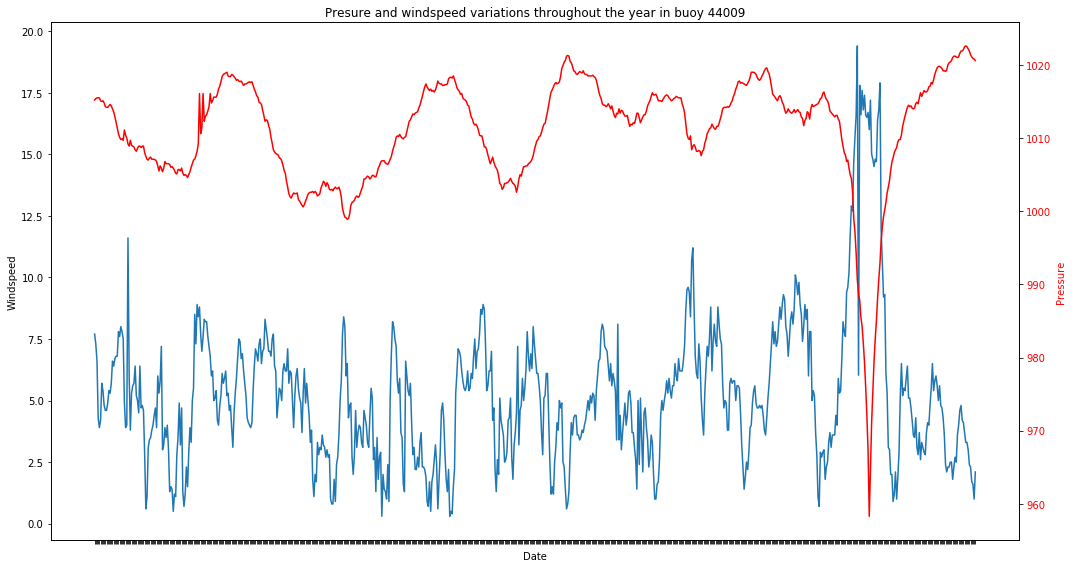

In [5]:
rs_09 = df_b7.loc[ (df_b7['month']==8)] #& ( (df_b7['day']==27) | (df_b7['day']==28) | (df_b7['day']==29) )]rs_09['date'] = rs_09['datetime'].astype('datetime64[ns]')
rs_09['date'] = rs_09['datetime'].astype('datetime64[ns]')
rs_09.head()
plot_df(rs_09, x=rs_09.datetime,y1=rs_09.windspeed, y2=rs_09.pressure, title='Presure and windspeed variations throughout the year in buoy 44009',xlabel="Date",data="year")




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



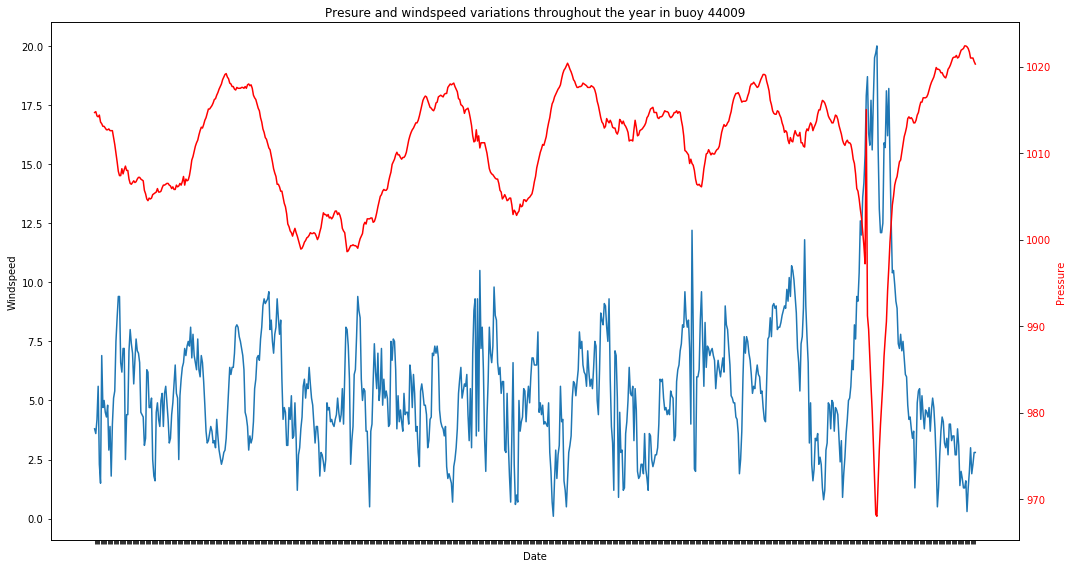

In [6]:
rs_65 = df_b8.loc[ (df_b8['month']==8)]# & ( (df_b8['day']==27) | (df_b8['day']==28) | (df_b8['day']==29) )]
rs_65['date'] = rs_65['datetime'].astype('datetime64[ns]')
rs_65.head()
plot_df(rs_65, x=rs_65.datetime,y1=rs_65.windspeed, y2=rs_65.pressure, title='Presure and windspeed variations throughout the year in buoy 44009',xlabel="Date",data="year")


Text(0.5, 0, 'Pressure(in hPA)')

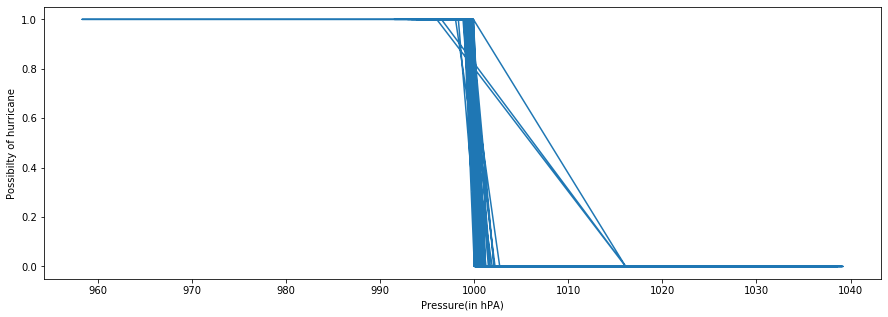

In [7]:
#the possibility coulmn has value 1 if the pressure is less than 1000, which seems to be the threshold value for
#indication of hurricane

x=df_b7['pressure']
y1=df_b7['possibility']
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.plot(x, y1)
ax1.set_ylabel('Possibilty of hurricane')
ax1.set_xlabel('Pressure(in hPA)')

Since we need to predict if occurence of hurricane is possible or not given these readings, logistic regression seems to be a good choice to predict the outcome variable, i.e, 'possibility'.

In [8]:
y1.value_counts()

0.0    8514
1.0     190
Name: possibility, dtype: int64

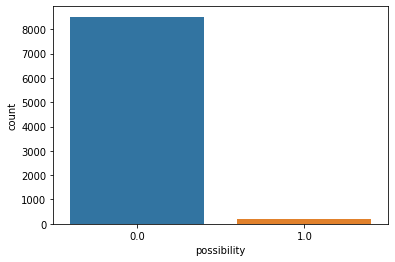

In [9]:
sns.countplot(x='possibility',data=df_b7)
plt.show()

In [10]:
count_no_sub = len(y1[y1==0])
count_sub = len(y1[y1==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Percentage of instances with no occurence of hurricane ", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Percentage of instances where hurricane actually occured", pct_of_sub*100)

Percentage of instances with no occurence of hurricane  97.81709558823529
Percentage of instances where hurricane actually occured 2.1829044117647056


INFERENCE:
There is a gross imbalance of data. There are very small number of intances of actual interest.

OBSERVATIONS SO FAR:
Pressure and windspeed are the features most affected by the occurence of a hurricane.
There are a very few instances of interest.

Let us try to upsample the no-hurricane data using the SMOTE algorithm(Synthetic Minority Oversampling Technique).
A few facts about SMOTE:
1)Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
2)Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

We will over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

In [11]:
#taking a set of possible predictor variables
keep_col = ['day','month','waveperiod','waveheight','WindDir','windspeed','pressure']

X = df_b7[keep_col]
y = df_b7['possibility']

os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['possibility'])
# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no hurricane (possibility=0) readings in oversampled data",len(os_data_y[os_data_y['possibility']==0]))
print("Number of hurricane occurence readings",len(os_data_y[os_data_y['possibility']==1]))
print("Proportion of no hurricane data in oversampled data is ",len(os_data_y[os_data_y['possibility']==0])/len(os_data_X))
print("Proportion of hurricane data in oversampled data is ",len(os_data_y[os_data_y['possibility']==1])/len(os_data_X))

Length of oversampled data is  11904
Number of no hurricane (possibility=0) readings in oversampled data 5952
Number of hurricane occurence readings 5952
Proportion of no hurricane data in oversampled data is  0.5
Proportion of hurricane data in oversampled data is  0.5


Now, the question arises , which features to take as predictor variables ?
Irrelevant or partially relevant features can negatively impact model performance.
The main problem is that factors like day, month, hour and minute obviously do not affect the occurence of a hurricane.
Features like pressure, windspeed and waveheight might change drastically in such events. 
Our previous visualisations and conclusions support this fact.
Let's just try building a model using these features.

In [12]:
keep_col = ['windspeed','pressure','waveheight']
df_b7_logit = os_data_X[keep_col]
y1=os_data_y['possibility']


In [13]:
X_train, x_test, y_train, y_test = train_test_split(df_b7_logit,y1,test_size=0.3, random_state=0)

In [14]:
logreg = LogisticRegression()
result=logreg.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [15]:
#keep_col_new=['pressure']
#new_x= df_b7_init[keep_col_new]
#y1=df_b7_init['hurrthreat']
#X_t, X_tes, y_t, y_tes = train_test_split(new_x, y1, test_size=0.3, random_state=0)

#model.fit(X_t, y_t)
y_pred = logreg.predict(x_test)
x_test.head()
#X_tes.iloc[3]
for i in range(len(x_test)):
    if(y_pred[i]==1):
        print("%s, Predicted=%s" % (x_test.iloc[i], y_pred[i]))

windspeed       7.836069
pressure      999.000205
waveheight      1.737829
Name: 8745, dtype: float64, Predicted=1.0
windspeed       8.397315
pressure      999.248657
waveheight      1.700405
Name: 7131, dtype: float64, Predicted=1.0
windspeed      16.045903
pressure      996.085424
waveheight      9.000000
Name: 9020, dtype: float64, Predicted=1.0
windspeed      14.714093
pressure      981.612299
waveheight      3.758725
Name: 6169, dtype: float64, Predicted=1.0
windspeed       9.578542
pressure      998.991845
waveheight      2.816696
Name: 10760, dtype: float64, Predicted=1.0
windspeed      10.692800
pressure      998.634585
waveheight      2.184006
Name: 8018, dtype: float64, Predicted=1.0
windspeed       8.667915
pressure      999.006148
waveheight      1.518156
Name: 11676, dtype: float64, Predicted=1.0
windspeed      13.567459
pressure      997.102376
waveheight      2.883407
Name: 9157, dtype: float64, Predicted=1.0
windspeed       7.729769
pressure      996.279640
waveheight  

Name: 8283, dtype: float64, Predicted=1.0
windspeed      13.145194
pressure      994.404089
waveheight      6.700572
Name: 11474, dtype: float64, Predicted=1.0
windspeed      10.598630
pressure      998.904110
waveheight      1.775208
Name: 8648, dtype: float64, Predicted=1.0
windspeed      13.067573
pressure      998.192816
waveheight      2.098563
Name: 6839, dtype: float64, Predicted=1.0
windspeed       9.034877
pressure      996.873951
waveheight      1.798698
Name: 11115, dtype: float64, Predicted=1.0
windspeed      10.913555
pressure      998.690504
waveheight      2.211153
Name: 7159, dtype: float64, Predicted=1.0
windspeed       8.370646
pressure      998.333997
waveheight      2.811848
Name: 6116, dtype: float64, Predicted=1.0
windspeed       9.048273
pressure      996.267826
waveheight      2.317702
Name: 9951, dtype: float64, Predicted=1.0
windspeed       8.412767
pressure      995.230850
waveheight      1.994501
Name: 10987, dtype: float64, Predicted=1.0
windspeed       10.

Name: 6260, dtype: float64, Predicted=1.0
windspeed      12.139776
pressure      992.413978
waveheight      4.371997
Name: 6136, dtype: float64, Predicted=1.0
windspeed       7.942828
pressure      996.271212
waveheight      1.832656
Name: 11836, dtype: float64, Predicted=1.0
windspeed       8.795296
pressure      999.350882
waveheight      4.070357
Name: 6358, dtype: float64, Predicted=1.0
windspeed        7.9
pressure      1010.2
waveheight       9.0
Name: 3658, dtype: float64, Predicted=1.0
windspeed      11.576222
pressure      997.998811
waveheight      1.178573
Name: 8523, dtype: float64, Predicted=1.0
windspeed      16.548522
pressure      978.601974
waveheight      7.640986
Name: 6199, dtype: float64, Predicted=1.0
windspeed       10.50
pressure      1008.90
waveheight       1.71
Name: 2818, dtype: float64, Predicted=1.0
windspeed       4.736321
pressure      995.296856
waveheight      7.978170
Name: 8875, dtype: float64, Predicted=1.0
windspeed      12.024475
pressure      996

Name: 7059, dtype: float64, Predicted=1.0
windspeed      12.513913
pressure      992.451391
waveheight      6.384853
Name: 11521, dtype: float64, Predicted=1.0
windspeed      15.125241
pressure      992.208941
waveheight      2.586605
Name: 9897, dtype: float64, Predicted=1.0
windspeed      11.502468
pressure      998.364679
waveheight      2.063429
Name: 11180, dtype: float64, Predicted=1.0
windspeed       8.611211
pressure      998.416817
waveheight      1.333246
Name: 8440, dtype: float64, Predicted=1.0
windspeed       7.235765
pressure      999.587153
waveheight      3.165313
Name: 11285, dtype: float64, Predicted=1.0
windspeed       9.171221
pressure      995.785610
waveheight      2.282733
Name: 7660, dtype: float64, Predicted=1.0
windspeed       9.089024
pressure      995.842684
waveheight      8.696005
Name: 8198, dtype: float64, Predicted=1.0
windspeed      10.174975
pressure      997.260595
waveheight      2.273020
Name: 11296, dtype: float64, Predicted=1.0
windspeed      14.

Name: 7395, dtype: float64, Predicted=1.0
windspeed       8.670374
pressure      998.930629
waveheight      1.588478
Name: 10847, dtype: float64, Predicted=1.0
windspeed      15.909966
pressure      994.470448
waveheight      9.000000
Name: 7266, dtype: float64, Predicted=1.0
windspeed        9.70
pressure      1018.80
waveheight       1.37
Name: 3884, dtype: float64, Predicted=1.0
windspeed       8.459655
pressure      997.565884
waveheight      2.870086
Name: 8377, dtype: float64, Predicted=1.0
windspeed      16.450690
pressure      965.092543
waveheight      6.060751
Name: 8108, dtype: float64, Predicted=1.0
windspeed       11.90
pressure      1019.20
waveheight       1.93
Name: 2985, dtype: float64, Predicted=1.0
windspeed        9.60
pressure      1013.80
waveheight       1.75
Name: 1172, dtype: float64, Predicted=1.0
windspeed       7.614837
pressure      997.571291
waveheight      2.154355
Name: 6937, dtype: float64, Predicted=1.0
windspeed       8.108406
pressure      999.22168

windspeed      15.486165
pressure      998.933776
waveheight      3.043388
Name: 8961, dtype: float64, Predicted=1.0
windspeed      13.394294
pressure      996.548970
waveheight      9.000000
Name: 10943, dtype: float64, Predicted=1.0
windspeed       8.4
pressure      996.9
waveheight      9.0
Name: 3595, dtype: float64, Predicted=1.0
windspeed        8.8
pressure      1031.6
waveheight       9.0
Name: 335, dtype: float64, Predicted=1.0
windspeed      14.8
pressure      997.5
waveheight      9.0
Name: 1869, dtype: float64, Predicted=1.0
windspeed      14.276113
pressure      995.020848
waveheight      5.412213
Name: 6221, dtype: float64, Predicted=1.0
windspeed       12.30
pressure      1009.40
waveheight       1.54
Name: 1826, dtype: float64, Predicted=1.0
windspeed       11.40
pressure      1033.90
waveheight       2.12
Name: 1911, dtype: float64, Predicted=1.0
windspeed      11.842503
pressure      998.847501
waveheight      2.154370
Name: 8204, dtype: float64, Predicted=1.0
windspe

windspeed      11.310508
pressure      997.985525
waveheight      1.162630
Name: 9104, dtype: float64, Predicted=1.0
windspeed       11.40
pressure      1013.30
waveheight       1.67
Name: 2378, dtype: float64, Predicted=1.0
windspeed      12.826041
pressure      998.992509
waveheight      2.738823
Name: 9002, dtype: float64, Predicted=1.0
windspeed      10.218138
pressure      998.946087
waveheight      1.722472
Name: 8226, dtype: float64, Predicted=1.0
windspeed       9.027288
pressure      997.118136
waveheight      2.047221
Name: 6974, dtype: float64, Predicted=1.0
windspeed      13.497295
pressure      986.439219
waveheight      7.623457
Name: 11385, dtype: float64, Predicted=1.0
windspeed       9.836491
pressure      996.961140
waveheight      2.131658
Name: 11278, dtype: float64, Predicted=1.0
windspeed      16.547508
pressure      965.339395
waveheight      6.129212
Name: 7042, dtype: float64, Predicted=1.0
windspeed      14.073208
pressure      996.046417
waveheight      9.000

windspeed        9.000000
pressure      1016.085292
waveheight       9.000000
Name: 5296, dtype: float64, Predicted=1.0
windspeed       9.861082
pressure      999.549736
waveheight      2.462434
Name: 11581, dtype: float64, Predicted=1.0
windspeed       8.503421
pressure      997.620992
waveheight      1.896915
Name: 11358, dtype: float64, Predicted=1.0
windspeed       5.528786
pressure      995.342781
waveheight      5.416088
Name: 7466, dtype: float64, Predicted=1.0
windspeed       10.30
pressure      1013.90
waveheight       1.31
Name: 4847, dtype: float64, Predicted=1.0
windspeed       11.20
pressure      1024.30
waveheight       1.88
Name: 2272, dtype: float64, Predicted=1.0
windspeed       9.962437
pressure      998.238510
waveheight      2.187147
Name: 6782, dtype: float64, Predicted=1.0
windspeed      12.925394
pressure      979.703988
waveheight      4.088212
Name: 7673, dtype: float64, Predicted=1.0
windspeed      15.783107
pressure      980.609151
waveheight      3.880638
Na

Name: 7944, dtype: float64, Predicted=1.0
windspeed      18.222946
pressure      992.155393
waveheight      9.000000
Name: 11243, dtype: float64, Predicted=1.0
windspeed       11.00
pressure      1022.60
waveheight       1.66
Name: 4637, dtype: float64, Predicted=1.0
windspeed       8.822032
pressure      996.130089
waveheight      3.191451
Name: 10511, dtype: float64, Predicted=1.0
windspeed      10.121425
pressure      999.171607
waveheight      2.709106
Name: 6578, dtype: float64, Predicted=1.0
windspeed      10.314191
pressure      998.100102
waveheight      2.537152
Name: 10037, dtype: float64, Predicted=1.0
windspeed        5.8
pressure      1013.5
waveheight       9.0
Name: 530, dtype: float64, Predicted=1.0
windspeed      12.122762
pressure      996.374484
waveheight      9.000000
Name: 10546, dtype: float64, Predicted=1.0
windspeed       8.216059
pressure      995.667881
waveheight      1.998704
Name: 8260, dtype: float64, Predicted=1.0
windspeed      12.558284
pressure      9

Name: 1516, dtype: float64, Predicted=1.0
windspeed       9.483818
pressure      998.655864
waveheight      1.680823
Name: 9494, dtype: float64, Predicted=1.0
windspeed       6.497686
pressure      994.821540
waveheight      5.130245
Name: 6496, dtype: float64, Predicted=1.0
windspeed        5.1
pressure      1008.9
waveheight       9.0
Name: 5693, dtype: float64, Predicted=1.0
windspeed        9.00
pressure      1014.00
waveheight       1.44
Name: 949, dtype: float64, Predicted=1.0
windspeed      13.764763
pressure      999.424626
waveheight      3.204572
Name: 7902, dtype: float64, Predicted=1.0
windspeed       4.771684
pressure      995.486734
waveheight      9.000000
Name: 9651, dtype: float64, Predicted=1.0
windspeed      11.267184
pressure      999.458174
waveheight      2.582160
Name: 8781, dtype: float64, Predicted=1.0
windspeed       8.353633
pressure      998.310093
waveheight      1.319442
Name: 10070, dtype: float64, Predicted=1.0
windspeed      13.273619
pressure      995.

Name: 8243, dtype: float64, Predicted=1.0
windspeed       7.725813
pressure      994.562987
waveheight      2.486538
Name: 11455, dtype: float64, Predicted=1.0
windspeed      16.107773
pressure      967.877388
waveheight      5.029134
Name: 9832, dtype: float64, Predicted=1.0
windspeed       8.522222
pressure      996.813450
waveheight      5.871637
Name: 10956, dtype: float64, Predicted=1.0
windspeed      11.782013
pressure      993.539569
waveheight      9.000000
Name: 6759, dtype: float64, Predicted=1.0
windspeed       7.874579
pressure      999.003093
waveheight      1.754196
Name: 6958, dtype: float64, Predicted=1.0
windspeed       9.504792
pressure      996.928750
waveheight      2.226885
Name: 10142, dtype: float64, Predicted=1.0
windspeed      13.813613
pressure      992.905417
waveheight      4.138646
Name: 6893, dtype: float64, Predicted=1.0
windspeed      10.845109
pressure      995.670878
waveheight      2.938591
Name: 9458, dtype: float64, Predicted=1.0
windspeed       7.9

windspeed      11.624993
pressure      996.373224
waveheight      2.825355
Name: 10254, dtype: float64, Predicted=1.0
windspeed      13.549796
pressure      993.103691
waveheight      3.097976
Name: 10727, dtype: float64, Predicted=1.0
windspeed      17.773173
pressure      991.082964
waveheight      9.000000
Name: 6530, dtype: float64, Predicted=1.0
windspeed      16.088213
pressure      959.434162
waveheight      6.247317
Name: 8671, dtype: float64, Predicted=1.0
windspeed      11.543748
pressure      993.875609
waveheight      9.000000
Name: 9368, dtype: float64, Predicted=1.0
windspeed      15.662829
pressure      997.191422
waveheight      9.000000
Name: 8852, dtype: float64, Predicted=1.0
windspeed       9.898171
pressure      998.126585
waveheight      1.950921
Name: 10051, dtype: float64, Predicted=1.0
windspeed       10.2
pressure      1016.5
waveheight       9.0
Name: 4578, dtype: float64, Predicted=1.0
windspeed      10.757121
pressure      995.393444
waveheight      2.67141

Name: 11250, dtype: float64, Predicted=1.0
windspeed       10.50
pressure      1014.50
waveheight       1.73
Name: 843, dtype: float64, Predicted=1.0
windspeed      11.376976
pressure      987.081060
waveheight      6.682759
Name: 8500, dtype: float64, Predicted=1.0
windspeed       7.139224
pressure      999.567845
waveheight      3.113181
Name: 10136, dtype: float64, Predicted=1.0
windspeed       7.894612
pressure      995.909586
waveheight      1.497550
Name: 8493, dtype: float64, Predicted=1.0
windspeed       9.575380
pressure      994.373557
waveheight      1.151338
Name: 11234, dtype: float64, Predicted=1.0
windspeed       9.021111
pressure      995.710556
waveheight      2.192667
Name: 7068, dtype: float64, Predicted=1.0
windspeed       10.20
pressure      1024.30
waveheight       1.82
Name: 390, dtype: float64, Predicted=1.0
windspeed      14.249766
pressure      993.614553
waveheight      2.746176
Name: 8307, dtype: float64, Predicted=1.0
windspeed      12.393651
pressure      

Name: 8252, dtype: float64, Predicted=1.0
windspeed      11.293142
pressure      999.582855
waveheight      1.853660
Name: 6178, dtype: float64, Predicted=1.0
windspeed      13.449605
pressure      995.722852
waveheight      3.947013
Name: 10533, dtype: float64, Predicted=1.0
windspeed       4.840887
pressure      995.681773
waveheight      7.274586
Name: 10507, dtype: float64, Predicted=1.0
windspeed       10.60
pressure      1017.90
waveheight       1.32
Name: 2049, dtype: float64, Predicted=1.0
windspeed       9.746347
pressure      998.711626
waveheight      2.589568
Name: 9374, dtype: float64, Predicted=1.0
windspeed      14.058361
pressure      994.415526
waveheight      3.878721
Name: 7044, dtype: float64, Predicted=1.0
windspeed       8.590390
pressure      999.318078
waveheight      1.510984
Name: 8392, dtype: float64, Predicted=1.0
windspeed       14.4
pressure      1014.8
waveheight       1.9
Name: 5843, dtype: float64, Predicted=1.0
windspeed        9.30
pressure      1000.

windspeed      16.949211
pressure      981.001317
waveheight      3.910901
Name: 11098, dtype: float64, Predicted=1.0
windspeed       8.662592
pressure      999.345395
waveheight      2.389201
Name: 6158, dtype: float64, Predicted=1.0
windspeed       12.40
pressure      1013.10
waveheight       1.99
Name: 1514, dtype: float64, Predicted=1.0
windspeed       10.90
pressure      1025.30
waveheight       1.41
Name: 3431, dtype: float64, Predicted=1.0
windspeed      12.729309
pressure      994.917431
waveheight      2.934732
Name: 11821, dtype: float64, Predicted=1.0
windspeed        9.70
pressure      1015.30
waveheight       1.44
Name: 3639, dtype: float64, Predicted=1.0
windspeed       9.777004
pressure      996.148968
waveheight      2.307326
Name: 8277, dtype: float64, Predicted=1.0
windspeed        9.7
pressure      1014.3
waveheight       1.6
Name: 1215, dtype: float64, Predicted=1.0
windspeed      14.058186
pressure      997.406902
waveheight      9.000000
Name: 9643, dtype: float64

windspeed       8.410340
pressure      996.669654
waveheight      1.713377
Name: 6311, dtype: float64, Predicted=1.0
windspeed      12.154527
pressure      993.901052
waveheight      3.036148
Name: 11414, dtype: float64, Predicted=1.0
windspeed      15.909276
pressure      996.139704
waveheight      3.424564
Name: 8918, dtype: float64, Predicted=1.0
windspeed      10.641933
pressure      994.000579
waveheight      6.229430
Name: 6219, dtype: float64, Predicted=1.0
windspeed       9.931900
pressure      996.826026
waveheight      1.927631
Name: 10331, dtype: float64, Predicted=1.0
windspeed       14.50
pressure      1021.20
waveheight       3.75
Name: 4166, dtype: float64, Predicted=1.0
windspeed      11.328471
pressure      995.169396
waveheight      2.498968
Name: 8979, dtype: float64, Predicted=1.0
windspeed       14.40
pressure      1002.10
waveheight       3.04
Name: 3073, dtype: float64, Predicted=1.0
windspeed        5.5
pressure      1012.3
waveheight       9.0
Name: 49, dtype: 

Name: 9054, dtype: float64, Predicted=1.0
windspeed      11.890977
pressure      996.640351
waveheight      2.342957
Name: 11557, dtype: float64, Predicted=1.0
windspeed       8.821377
pressure      997.578623
waveheight      4.932517
Name: 6597, dtype: float64, Predicted=1.0
windspeed       8.358517
pressure      996.975981
waveheight      1.927990
Name: 10630, dtype: float64, Predicted=1.0
windspeed       9.005224
pressure      999.649052
waveheight      1.771946
Name: 11707, dtype: float64, Predicted=1.0
windspeed       8.124618
pressure      997.572325
waveheight      1.710306
Name: 9611, dtype: float64, Predicted=1.0
windspeed      13.660074
pressure      993.553358
waveheight      4.939940
Name: 10711, dtype: float64, Predicted=1.0
windspeed      14.339919
pressure      996.902619
waveheight      3.583085
Name: 10993, dtype: float64, Predicted=1.0
windspeed      15.339951
pressure      983.246090
waveheight      3.713381
Name: 7554, dtype: float64, Predicted=1.0
windspeed       1

In [16]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


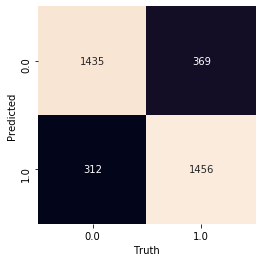

In [17]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_pred, y_test)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

In [18]:
df_b8_logit = df_b8_init[keep_col]
y2=df_b8_init['possibility']

In [25]:
y_pred2 = logreg.predict(df_b8_logit)
for i in range(len(df_b8_logit)):
    if(y_pred2[i]==1):
        print("%s, Predicted=%s" % (df_b8_logit.iloc[i], y_pred2[i]))

windspeed       10.40
pressure      1011.60
waveheight       0.59
Name: 51, dtype: float64, Predicted=1.0
windspeed       10.70
pressure      1012.70
waveheight       0.87
Name: 52, dtype: float64, Predicted=1.0
windspeed       12.30
pressure      1012.90
waveheight       1.09
Name: 53, dtype: float64, Predicted=1.0
windspeed       13.30
pressure      1013.30
waveheight       1.32
Name: 54, dtype: float64, Predicted=1.0
windspeed       12.00
pressure      1014.40
waveheight       1.48
Name: 55, dtype: float64, Predicted=1.0
windspeed       11.40
pressure      1015.50
waveheight       1.47
Name: 56, dtype: float64, Predicted=1.0
windspeed       12.50
pressure      1016.00
waveheight       1.32
Name: 57, dtype: float64, Predicted=1.0
windspeed       12.60
pressure      1016.80
waveheight       1.45
Name: 58, dtype: float64, Predicted=1.0
windspeed       13.50
pressure      1017.50
waveheight       1.34
Name: 59, dtype: float64, Predicted=1.0
windspeed       13.40
pressure      1018.30
wa

Name: 552, dtype: float64, Predicted=1.0
windspeed       10.70
pressure      1024.60
waveheight       0.79
Name: 555, dtype: float64, Predicted=1.0
windspeed       12.00
pressure      1025.30
waveheight       0.96
Name: 556, dtype: float64, Predicted=1.0
windspeed       12.50
pressure      1026.20
waveheight       1.14
Name: 557, dtype: float64, Predicted=1.0
windspeed       11.00
pressure      1027.00
waveheight       1.05
Name: 558, dtype: float64, Predicted=1.0
windspeed        9.70
pressure      1012.90
waveheight       1.29
Name: 615, dtype: float64, Predicted=1.0
windspeed        9.9
pressure      1010.7
waveheight       1.3
Name: 616, dtype: float64, Predicted=1.0
windspeed       10.5
pressure      1009.0
waveheight       9.0
Name: 617, dtype: float64, Predicted=1.0
windspeed       11.30
pressure      1006.90
waveheight       1.57
Name: 618, dtype: float64, Predicted=1.0
windspeed       11.90
pressure      1005.30
waveheight       1.62
Name: 619, dtype: float64, Predicted=1.0
wi

Name: 1332, dtype: float64, Predicted=1.0
windspeed      14.50
pressure      991.10
waveheight      3.26
Name: 1333, dtype: float64, Predicted=1.0
windspeed      14.10
pressure      989.60
waveheight      3.14
Name: 1334, dtype: float64, Predicted=1.0
windspeed      13.00
pressure      988.30
waveheight      2.91
Name: 1335, dtype: float64, Predicted=1.0
windspeed      15.7
pressure      992.0
waveheight      3.0
Name: 1338, dtype: float64, Predicted=1.0
windspeed      17.00
pressure      995.80
waveheight      2.97
Name: 1339, dtype: float64, Predicted=1.0
windspeed       13.70
pressure      1000.40
waveheight       2.94
Name: 1340, dtype: float64, Predicted=1.0
windspeed       16.50
pressure      1004.50
waveheight       2.61
Name: 1341, dtype: float64, Predicted=1.0
windspeed       14.60
pressure      1007.90
waveheight       2.44
Name: 1342, dtype: float64, Predicted=1.0
windspeed       16.00
pressure      1011.10
waveheight       2.24
Name: 1343, dtype: float64, Predicted=1.0
wind

Name: 2097, dtype: float64, Predicted=1.0
windspeed        9.80
pressure      1009.20
waveheight       0.48
Name: 2142, dtype: float64, Predicted=1.0
windspeed       10.0
pressure      1009.9
waveheight       0.7
Name: 2143, dtype: float64, Predicted=1.0
windspeed        9.80
pressure      1008.90
waveheight       1.14
Name: 2149, dtype: float64, Predicted=1.0
windspeed       10.20
pressure      1008.20
waveheight       1.36
Name: 2150, dtype: float64, Predicted=1.0
windspeed        9.90
pressure      1007.30
waveheight       1.49
Name: 2151, dtype: float64, Predicted=1.0
windspeed        9.80
pressure      1007.00
waveheight       1.75
Name: 2152, dtype: float64, Predicted=1.0
windspeed       10.10
pressure      1005.50
waveheight       1.62
Name: 2153, dtype: float64, Predicted=1.0
windspeed        8.90
pressure      1005.70
waveheight       1.65
Name: 2154, dtype: float64, Predicted=1.0
windspeed        9.50
pressure      1004.90
waveheight       1.75
Name: 2155, dtype: float64, Pre

windspeed        8.80
pressure      1010.80
waveheight       1.85
Name: 3277, dtype: float64, Predicted=1.0
windspeed        9.20
pressure      1011.50
waveheight       1.63
Name: 3278, dtype: float64, Predicted=1.0
windspeed        8.90
pressure      1011.70
waveheight       1.67
Name: 3280, dtype: float64, Predicted=1.0
windspeed       11.0
pressure      1010.5
waveheight       9.0
Name: 3281, dtype: float64, Predicted=1.0
windspeed       11.40
pressure      1010.50
waveheight       1.84
Name: 3282, dtype: float64, Predicted=1.0
windspeed       11.60
pressure      1011.50
waveheight       2.09
Name: 3283, dtype: float64, Predicted=1.0
windspeed       12.30
pressure      1011.80
waveheight       2.17
Name: 3284, dtype: float64, Predicted=1.0
windspeed       10.40
pressure      1012.00
waveheight       2.06
Name: 3285, dtype: float64, Predicted=1.0
windspeed       10.7
pressure      1012.3
waveheight       9.0
Name: 3286, dtype: float64, Predicted=1.0
windspeed       11.9
pressure     

Name: 6223, dtype: float64, Predicted=1.0
windspeed       12.20
pressure      1005.90
waveheight       2.63
Name: 6224, dtype: float64, Predicted=1.0
windspeed       13.10
pressure      1006.10
waveheight       2.46
Name: 6225, dtype: float64, Predicted=1.0
windspeed       12.90
pressure      1006.20
waveheight       2.39
Name: 6226, dtype: float64, Predicted=1.0
windspeed       11.90
pressure      1006.80
waveheight       2.47
Name: 6227, dtype: float64, Predicted=1.0
windspeed       11.80
pressure      1007.20
waveheight       2.58
Name: 6228, dtype: float64, Predicted=1.0
windspeed       11.40
pressure      1007.50
waveheight       2.13
Name: 6229, dtype: float64, Predicted=1.0
windspeed       10.70
pressure      1008.10
waveheight       2.02
Name: 6230, dtype: float64, Predicted=1.0
windspeed       10.40
pressure      1009.00
waveheight       2.16
Name: 6231, dtype: float64, Predicted=1.0
windspeed       10.00
pressure      1010.10
waveheight       1.89
Name: 6232, dtype: float64, 

Name: 7169, dtype: float64, Predicted=1.0
windspeed        9.80
pressure      1009.60
waveheight       1.14
Name: 7175, dtype: float64, Predicted=1.0
windspeed       11.00
pressure      1007.80
waveheight       1.36
Name: 7177, dtype: float64, Predicted=1.0
windspeed       10.00
pressure      1007.20
waveheight       1.55
Name: 7178, dtype: float64, Predicted=1.0
windspeed        8.80
pressure      1007.10
waveheight       1.53
Name: 7179, dtype: float64, Predicted=1.0
windspeed       10.40
pressure      1006.70
waveheight       1.79
Name: 7181, dtype: float64, Predicted=1.0
windspeed        9.90
pressure      1005.10
waveheight       1.73
Name: 7184, dtype: float64, Predicted=1.0
windspeed        9.8
pressure      1004.3
waveheight       1.8
Name: 7185, dtype: float64, Predicted=1.0
windspeed        8.30
pressure      1005.00
waveheight       1.75
Name: 7186, dtype: float64, Predicted=1.0
windspeed       11.30
pressure      1004.80
waveheight       2.07
Name: 7187, dtype: float64, Pre

In [20]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(df_b8_logit, y2)))

Accuracy of logistic regression classifier on test set: 0.83


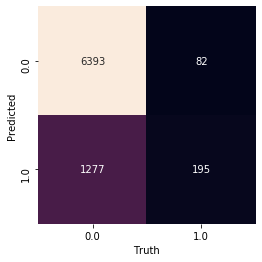

In [24]:
mat = confusion_matrix(y_pred2, y2)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

In [27]:
print(classification_report(y2, y_pred2 ))

              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      7670
         1.0       0.13      0.70      0.22       277

    accuracy                           0.83      7947
   macro avg       0.56      0.77      0.56      7947
weighted avg       0.96      0.83      0.88      7947



INTERPRETING THESE RESULTS

ACCURACY
In our dataset, the positive class — occurence of hurricane — is greatly outnumbered by the negative class. Accuracy is not a good measure for assessing model performance.